In [3]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn.metrics import confusion_matrix

import pylab

def imagesc(x):
    plt.imshow(x,extent = [0,1,0,1])

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
name_prefix = 'pol_van_co_16_left_' # to save figures

matfile_path ='co_van_16_left.mat'
matfile = loadmat(matfile_path)

ecog_trials = matfile['ecog_trials']
feat_trials = matfile['feat_trials']
posX_trials = matfile['posX_trials']
posY_trials = matfile['posY_trials']
par_trials = matfile['par_trials'][0]

del matfile

In [5]:
srate = 2048

numch_ecog = ecog_trials[0].shape[1]
fbandmins_len = feat_trials[0].shape[1]//numch_ecog

ch_idxs_motor = [18,19,20,21,48,49,50,51]

ch_idxs_all_motor = []

for c in ch_idxs_motor:
    feat_idxs_all = [c + numch_ecog*i for i in range(fbandmins_len)]
    for f in feat_idxs_all:
        ch_idxs_all_motor.append(f)
ch_idxs_all_motor.sort()
ch_idxs_all_motor = ch_idxs_all_motor[-16:]
print(ch_idxs_all_motor)

[278, 279, 280, 281, 308, 309, 310, 311, 330, 331, 332, 333, 360, 361, 362, 363]


In [6]:


step_div = 64

num_w = int(2.5*step_div)

win_starts = np.arange(num_w)*srate//step_div
print(win_starts)

win_ends = win_starts + srate//4
print(win_ends)


cms = np.zeros([num_w,8,8])



[   0   32   64   96  128  160  192  224  256  288  320  352  384  416
  448  480  512  544  576  608  640  672  704  736  768  800  832  864
  896  928  960  992 1024 1056 1088 1120 1152 1184 1216 1248 1280 1312
 1344 1376 1408 1440 1472 1504 1536 1568 1600 1632 1664 1696 1728 1760
 1792 1824 1856 1888 1920 1952 1984 2016 2048 2080 2112 2144 2176 2208
 2240 2272 2304 2336 2368 2400 2432 2464 2496 2528 2560 2592 2624 2656
 2688 2720 2752 2784 2816 2848 2880 2912 2944 2976 3008 3040 3072 3104
 3136 3168 3200 3232 3264 3296 3328 3360 3392 3424 3456 3488 3520 3552
 3584 3616 3648 3680 3712 3744 3776 3808 3840 3872 3904 3936 3968 4000
 4032 4064 4096 4128 4160 4192 4224 4256 4288 4320 4352 4384 4416 4448
 4480 4512 4544 4576 4608 4640 4672 4704 4736 4768 4800 4832 4864 4896
 4928 4960 4992 5024 5056 5088]
[ 512  544  576  608  640  672  704  736  768  800  832  864  896  928
  960  992 1024 1056 1088 1120 1152 1184 1216 1248 1280 1312 1344 1376
 1408 1440 1472 1504 1536 1568 1600 1632 1664

In [7]:
for w in range(len(win_starts)):

    feat_trials_red = [feat_trials[i][win_starts[w]:win_ends[w]:200,ch_idxs_all_motor].T for i in range(len(feat_trials))]

    feat_trials_red_flat = [feat_trials_red[i].reshape(-1) for i in range(len(feat_trials))]
    feat_trials_red_flat = np.array(feat_trials_red_flat)


    # find optimal C
    Cc_list = [50, 100, 500, 1000, 2000, 5000]

    Cc_scores = np.zeros(len(Cc_list))

    numit = 500

    k = 0
    for Cc in Cc_list:

        scores = np.zeros(numit)

        res_true = []
        res_pred = []

        for it in range(500):
            X_train, X_test, y_train, y_test = train_test_split(feat_trials_red_flat, par_trials, test_size=0.2)

            clf =  svm.SVC(kernel='rbf', C = Cc, shrinking = True).fit(X_train, y_train)

            scores[it] = clf.score(X_test, y_test)

            pred = clf.predict(X_test)
            res_pred.append(pred)
            res_true.append(y_test)

        #plt.hist(scores)

        #print(Cc)
        #print(np.mean(scores))
        Cc_scores[k] = np.mean(scores)

        k = k+1


    # use best C to build the classifier
    best_Cc_idx = np.argmax(Cc_scores)

    Cc = Cc_list[best_Cc_idx]

    scores = np.zeros(numit)

    res_true = []
    res_pred = []

    for it in range(500):
        X_train, X_test, y_train, y_test = train_test_split(feat_trials_red_flat, par_trials, test_size=0.2, stratify=par_trials)

        clf =  svm.SVC(kernel='rbf', C = Cc, shrinking = True).fit(X_train, y_train)

        scores[it] = clf.score(X_test, y_test)

        pred = clf.predict(X_test)
        res_pred.append(pred)
        res_true.append(y_test)

    print(Cc)
    print(np.mean(scores))
    
    
    # draw and save confusion matrix
    res_pred_flat = np.array(res_pred).reshape(-1)
    res_true_flat = np.array(res_true).reshape(-1)
    
    cm = confusion_matrix(res_true_flat,res_pred_flat)
    cms[w,:,:] = cm
    #plt.rcParams['figure.figsize'] = [10, 5]
    #plt.figure
    #imagesc(cm)
    #pylab.savefig(name_prefix+'cm_'+str(w))
    #plt.gcf().clear()
    
    print('w = ')
    print(w)
    #print(cm)
    print(np.diag(cm)/np.sum(cm,axis=1))
    

    fig = plt.figure(figsize=(20,5))
    rect = fig.patch
    plt.gcf().clear()

    for p in range(8):
        ax = plt.subplot(1,8,p+1, polar=True)

        angles = [n*3.14/4 for n in range(8)]
        angles += angles[:1]

        cm_to_plot = np.concatenate((cm[p,:],[cm[p,0]]),axis=0)
        cm_to_plot.shape

        plt.plot(angles,cm_to_plot)
        plt.plot([angles[p],angles[p]],[0,200],'m')

        ax.set_rticks([]) 
        
        ms_into_trial = w*srate//step_div
        
        
        win_flash = 128
        if(ms_into_trial > 2048-win_flash)and(ms_into_trial < 2048+win_flash):
            ax.set_facecolor('xkcd:mint green')
        else:
            ax.set_facecolor('white')
            
    if(ms_into_trial > 2048):
        plt.suptitle(str(ms_into_trial-2048)+' ms since GO-signal')
    else:
        plt.suptitle(str(2048-ms_into_trial)+' ms to GO-signal')
    
    pylab.savefig(name_prefix+'polar_'+str(w))
    plt.gcf().clear()
    

500
0.1485
w = 
0
[[ 12 249   2  28  65  22  98  24]
 [191 146   9  49   5  63   9  28]
 [ 29 116 115  88   1  66  60  25]
 [ 72 137 133  82  19   8  19  30]
 [ 25  56   3   5  89 175 136  11]
 [ 55 131  36  34 116  26  11  91]
 [144  27  70   6 183  12   0  58]
 [ 64  79  25   0  18 122  68 124]]
[0.024 0.292 0.23  0.164 0.178 0.052 0.    0.248]
2000
0.1695
w = 
1
[[ 19 216   1  52  69  17  99  27]
 [228 110  14  36   2  70  18  22]
 [ 14 114 125 109   3  59  58  18]
 [115 117 144  66  28   3  21   6]
 [ 13  53  10   4  97 207 103  13]
 [ 56 125  10   8 112 121   7  61]
 [133  18  96  12 158  14   0  69]
 [ 77  62  29   0  21 109  62 140]]
[0.038 0.22  0.25  0.132 0.194 0.242 0.    0.28 ]
2000
0.18275
w = 
2
[[  5 215   0  73  75  14  84  34]
 [232 138   2  36   0  45  31  16]
 [ 10  86 161 109   1  52  43  38]
 [141 113 136  54  13  27  16   0]
 [  9  34   6   3  90 246 101  11]
 [ 33 120  24   4 110 121   3  85]
 [118  33 102   6 164  19   2  56]
 [ 89  48  25   0  33  88  57 160]]


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


500
0.14
w = 
21
[[  7  86   2  67   5  54  60 219]
 [114  92  13 154   0 106  10  11]
 [  4  67  41 305  31  20  32   0]
 [ 20  32 259   0  41 145   3   0]
 [ 46   0  80  43 169 112  50   0]
 [114  36   7  91 174  69   9   0]
 [149   5  77  27 108   2  12 120]
 [256   0   4  31   0   5  34 170]]
[0.014 0.184 0.082 0.    0.338 0.138 0.024 0.34 ]
2000
0.142
w = 
22
[[  4  82   4  83   6  82  49 190]
 [128  93  26 126   0 103  15   9]
 [ 28  63  46 298  29  12  24   0]
 [ 19  33 258   1  55 127   6   1]
 [ 42   0  81  30 218  91  38   0]
 [103  28   3 104 205  45   7   5]
 [168  12  70  31  87  13  11 108]
 [266   0   1  42   0   3  38 150]]
[0.008 0.186 0.092 0.002 0.436 0.09  0.022 0.3  ]
5000
0.1585
w = 
23
[[ 14  78   8  88  18  72  55 167]
 [162  62  25 141   0  82   9  19]
 [ 43  60  85 253  27  12  20   0]
 [ 52  31 201   0  68 140   2   6]
 [ 30   0  80  34 215  82  59   0]
 [ 94  21   2 105 199  65   6   8]
 [198   8  29  15  96  19  22 113]
 [243   0   1  50   0   2  33 171]]
[

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

In [8]:
acc = [np.diag(cms[i])/np.sum(cms[i],axis=1) for i in range(num_w)]

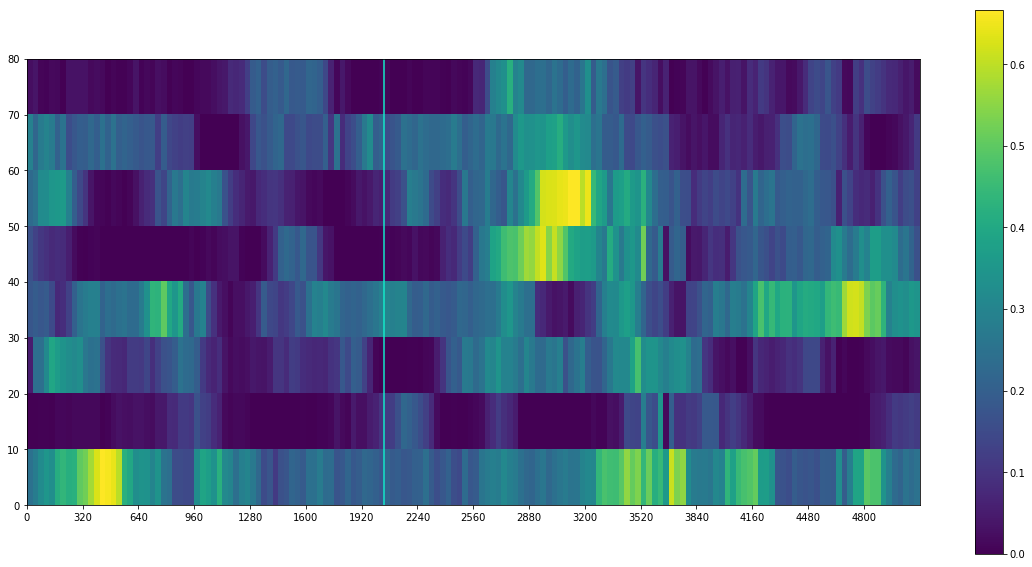

In [52]:
acc_np = np.array(acc)
acc_np.shape

plt.imshow(acc_np.T,extent = [0,160,0,80])
plt.xticks(np.arange(0, 160, step=10), win_starts[::10])
plt.axvline(2048//32,color='xkcd:aqua')
plt.colorbar()